In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



Matplotlib is building the font cache; this may take a moment.


In [5]:
# -------------------------
# 1. Ler datasets
# -------------------------
df_header   = pd.read_csv("dataset/PE_Header.csv")
df_section  = pd.read_csv("dataset/PE_Section.csv")
df_imports  = pd.read_csv("dataset/DLLs_Imported.csv")

# -------------------------
# 2. Garantir nomes consistentes
# -------------------------
# Caso alguma base venha com 'sha256' minúsculo etc.
for df in [df_header, df_section, df_imports]:
    df.rename(columns={c: c.upper() for c in df.columns}, inplace=True)

# -------------------------
# 3. Remover colunas duplicadas ANTES do merge
# (exceto SHA256)
# -------------------------
def drop_duplicate_cols(df):
    cols = df.columns
    dedup_cols = cols.drop_duplicates(keep='first')
    return df[dedup_cols]

df_header  = drop_duplicate_cols(df_header)
df_section = drop_duplicate_cols(df_section)
df_imports = drop_duplicate_cols(df_imports)

# -------------------------
# 4. Merge incremental por SHA256
# (inner = somente arquivos presentes em todas as bases)
# -------------------------
df_merged = df_header.merge(df_section, on="SHA256", how="inner")
df_merged = df_merged.merge(df_imports, on="SHA256", how="inner")

# -------------------------
# 5. Remover colunas duplicadas pós-merge (só por segurança)
# -------------------------
df_merged = df_merged.loc[:, ~df_merged.columns.duplicated()]

# -------------------------
# 6. Exibir resultado
# -------------------------
print("Shape final:", df_merged.shape)
print(df_merged.head())
df_merged.to_csv('./dataset/full_df.csv')


Shape final: (29495, 775)
                                              SHA256  TYPE_x  E_MAGIC  E_CBLP  \
0  dacbe8cb72dd746539792a50e84965fefef73feaa07b5d...       0    23117     144   
1  d3dc7512ce75db33b2c3063fa99245e9ca9fe3b086462f...       0    23117     144   
2  b350fac81533f02981dc2176ed17163177d92d9405758e...       0    23117     144   
3  dfee618043a47b7b09305df0ca460559d9f567ee246c7b...       0    23117     144   
4  c7b2e4e4fb2fcc44c953673ff57c3d14bdf5d2008f35e9...       0    23117     144   

   E_CP  E_CRLC  E_CPARHDR  E_MINALLOC  E_MAXALLOC  E_SS  ...  ODBCCP32.DLL  \
0     3       0          4           0       65535     0  ...             0   
1     3       0          4           0       65535     0  ...             0   
2     3       0          4           0       65535     0  ...             0   
3     3       0          4           0       65535     0  ...             0   
4     3       0          4           0       65535     0  ...             0   

   API-MS-WI

In [6]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ============================
# CONFIGURAÇÃO
# ============================
DATA_PATH = "./dataset/full_df.csv"
OUT_DIR = "./eda_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

TARGET_COL = "LABEL"     # iremos detectar automaticamente abaixo
EXPECTED_CLASSES = set(range(0,7))     # 0..6
# ============================


# =====================================================
# 1) CARREGAR BASE FINAL
# =====================================================
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset não encontrado em: {DATA_PATH}")

df = pd.read_csv(DATA_PATH)

print("Dataset carregado:", df.shape)


# =====================================================
# 2) DETECTAR COLUNA ALVO AUTOMATICAMENTE
# =====================================================
possible_target_cols = []

for col in df.columns:
    if df[col].dtype in [np.int64, np.int32, np.int16]:
        unique_vals = set(df[col].unique())
        if unique_vals.issubset(EXPECTED_CLASSES):
            possible_target_cols.append(col)

if len(possible_target_cols) == 0:
    raise ValueError("Nenhuma coluna compatível com os rótulos 0-6 foi encontrada.")

TARGET_COL = possible_target_cols[0]
print("Coluna alvo detectada:", TARGET_COL)


# =====================================================
# 3) SEPARAR FEATURES NUMÉRICAS
# =====================================================
exclude = {TARGET_COL, "SHA256"} if "SHA256" in df.columns else {TARGET_COL}

numeric_cols = [
    c for c in df.select_dtypes(include=[np.number]).columns
    if c not in exclude
]

print("Total de features numéricas:", len(numeric_cols))


# =====================================================
# 4) ESTATÍSTICAS DESCRITIVAS
# =====================================================
desc = df[numeric_cols].describe().T
desc["skew"] = df[numeric_cols].skew()
desc["kurt"] = df[numeric_cols].kurtosis()

desc.to_csv(os.path.join(OUT_DIR, "descriptive_stats_numeric.csv"))
print("Estatísticas descritivas salvas.")


# =====================================================
# 5) DISTRIBUIÇÃO DAS CLASSES
# =====================================================
counts = df[TARGET_COL].value_counts().sort_index()
plt.figure(figsize=(6,4))
counts.plot(kind="bar")
plt.title("Distribuição das Classes (0 = Benigno, 1-6 Tipos de Malware)")
plt.xlabel("Classe")
plt.ylabel("Frequência")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "class_distribution.png"))
plt.close()


# =====================================================
# 6) HISTOGRAMAS DE FEATURES IMPORTANTES
# =====================================================
preferred = [
    "TIMEDATESTAMP","SIZEOFIMAGE","SIZEOFHEADERS",
    "ADDRESSOFENTRYPOINT","NUMBEROFSECTIONS","SIZEOFCODE"
]

features_to_plot = [f for f in preferred if f in numeric_cols]
if len(features_to_plot) < 6:
    features_to_plot += numeric_cols[: (6 - len(features_to_plot))]

features_to_plot = features_to_plot[:6]

for feat in features_to_plot:
    plt.hist(df[feat].dropna(), bins=60)
    plt.title(f"Histogram of {feat}")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"hist_{feat}.png"))
    plt.close()


# =====================================================
# 7) BOXPLOTS POR CLASSE (MULTICLASS)
# =====================================================
for feat in features_to_plot:
    data = [df[df[TARGET_COL] == c][feat].values for c in sorted(df[TARGET_COL].unique())]
    plt.boxplot(data, labels=[str(c) for c in sorted(df[TARGET_COL].unique())])
    plt.title(f"Boxplot of {feat} by Class (0-6)")
    plt.xlabel("Class")
    plt.ylabel(feat)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"box_{feat}.png"))
    plt.close()


# =====================================================
# 8) HEATMAP DE CORRELAÇÃO
# =====================================================
corr_cols = numeric_cols[:60] if len(numeric_cols) > 60 else numeric_cols
corr = df[corr_cols].corr()

plt.figure(figsize=(10,8))
plt.imshow(corr, aspect="auto", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(corr_cols)), corr_cols, rotation=90, fontsize=7)
plt.yticks(range(len(corr_cols)), corr_cols, fontsize=7)
plt.title("Matriz de Correlação (Subset)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "corr_matrix.png"))
plt.close()


# =====================================================
# 9) PCA (2 COMPONENTES) + SCATTER MULTICLASS
# =====================================================
X = df[numeric_cols].values
# imputação simples de medianas
X = np.where(np.isfinite(X), X, np.nan)
col_med = np.nanmedian(X, axis=0)
inds = np.where(np.isnan(X))
X[inds] = np.take(col_med, inds[1])

Xs = StandardScaler().fit_transform(X)

pca2 = PCA(n_components=2, random_state=42)
Xp = pca2.fit_transform(Xs)

plt.figure(figsize=(7,6))
for c in sorted(df[TARGET_COL].unique()):
    mask = (df[TARGET_COL] == c).values
    plt.scatter(Xp[mask,0], Xp[mask,1], s=12, alpha=0.6, label=f"Class {c}")

plt.xlabel(f"PC1 ({pca2.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca2.explained_variance_ratio_[1]*100:.2f}%)")
plt.title("PCA (2 componentes) - Scatter multiclass")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pca_2comp_scatter.png"))
plt.close()


# =====================================================
# 10) CURVA DE VARIÂNCIA EXPLICADA
# =====================================================
pca_full = PCA(n_components=min(len(numeric_cols), 100), random_state=42)
pca_full.fit(Xs)

var_ratio = pca_full.explained_variance_ratio_
cum = np.cumsum(var_ratio)

nplot = min(50, len(var_ratio))

plt.figure(figsize=(8,5))
plt.plot(range(1, nplot+1), var_ratio[:nplot], marker="o")
plt.plot(range(1, nplot+1), cum[:nplot], marker="x")
plt.title("PCA – Variância Explicada (Primeiros Componentes)")
plt.xlabel("n componentes")
plt.ylabel("variância explicada / acumulada")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pca_variance.png"))
plt.close()


print("\nEDA FINALIZADO. Resultados salvos em:", OUT_DIR)


Dataset carregado: (29495, 776)
Coluna alvo detectada: TYPE_x
Total de features numéricas: 774
Estatísticas descritivas salvas.

EDA FINALIZADO. Resultados salvos em: ./eda_outputs


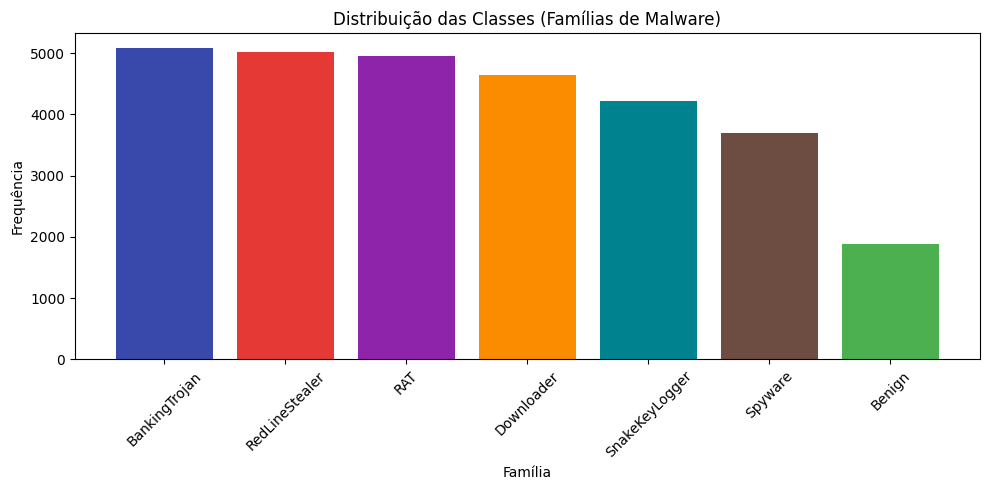

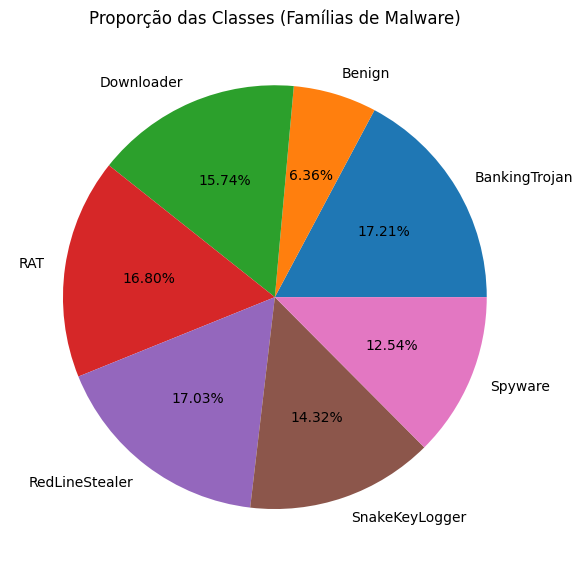

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Mapping das classes ---
malware_labels = {
    0: "Benign",
    1: "RedLineStealer",
    2: "Downloader",
    3: "RAT",
    4: "BankingTrojan",
    5: "SnakeKeyLogger",
    6: "Spyware"
}

# --- Cores definidas manualmente ---
colors = {
    "Benign": "#4CAF50",           # verde
    "RedLineStealer": "#E53935",   # vermelho
    "Downloader": "#FB8C00",       # laranja
    "RAT": "#8E24AA",              # roxo
    "BankingTrojan": "#3949AB",    # azul
    "SnakeKeyLogger": "#00838F",   # ciano
    "Spyware": "#6D4C41"           # marrom
}

# Carregar dataset
df = pd.read_csv("./dataset/full_df.csv")

# Criar coluna categórica
df["MalwareName"] = df["TYPE_x"].map(malware_labels)

# Contagem das classes
counts = df["MalwareName"].value_counts().sort_values(ascending=False)

# --- Barplot ordenado com cores definidas ---
plt.figure(figsize=(10, 5))
bars = plt.bar(counts.index, counts.values, color=[colors[label] for label in counts.index])

plt.title("Distribuição das Classes (Famílias de Malware)")
plt.xlabel("Família")
plt.ylabel("Frequência")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# --- Gráfico 2: Proporção das classes ---
plt.figure(figsize=(6, 6))
df["MalwareName"].value_counts(normalize=True).sort_index().plot(kind="pie", autopct="%.2f%%")
plt.title("Proporção das Classes (Famílias de Malware)")
plt.ylabel("")
plt.tight_layout()
plt.show()


In [14]:
df = pd.read_csv('./dataset/DLLs_Imported.csv')

df.describe

<bound method NDFrame.describe of                                                   SHA256  Type  advapi32.dll  \
0      002ce0d28ec990aadbbc89df457189de37d8adaadc9c08...     0             1   
1      2a053f32b1d48539e3e2807f86754be87ce95b08378467...     0             1   
2      2f031a1752f7067fb9f483ae0ac5f3036c9b66cc4af40e...     0             1   
3      308e8bb2e8a3b67607d2454370e0b50147b42049bda813...     0             1   
4      31aaba443b9869e6e68c17125f8d7989cbd762fb38ae3a...     0             1   
...                                                  ...   ...           ...   
29493  d1c923ec32d09be96adf3ba85e1855402f782b74437534...     6             0   
29494  d1dfc3203d99c0d54351bebd876762f27c0073e3cfef9a...     6             0   
29495  d1fea52507fc97ff419f8dd2ea8ecf689fb7c066cf8f18...     6             0   
29496  d201d8488d316c9ab7d537545efeda284568a652f23db1...     6             0   
29497  d207f51e336ab58868189d7826ef4fa2c897ae606ea744...     6             0   

     

Total DLL features detectadas: 625


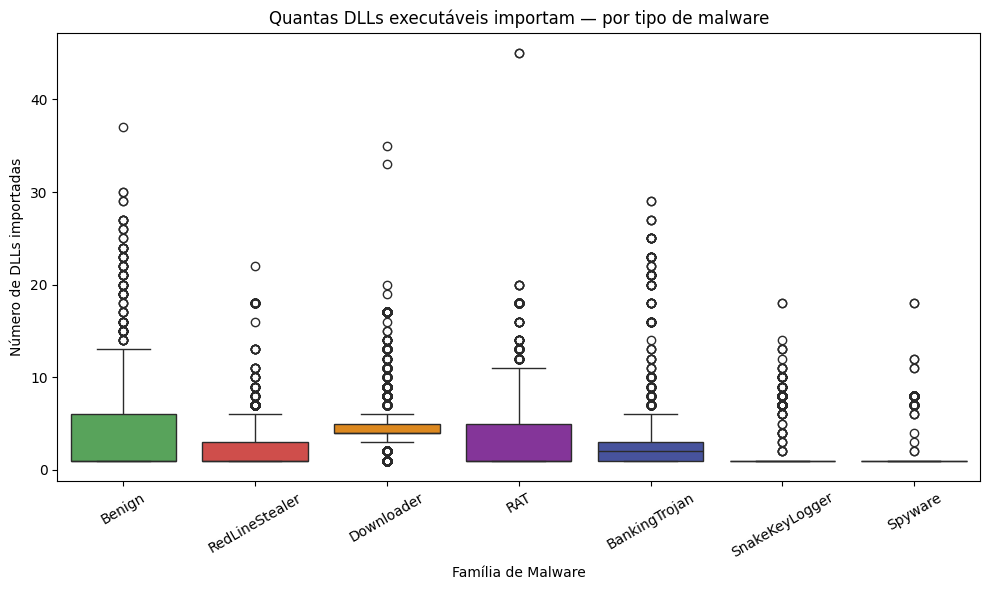

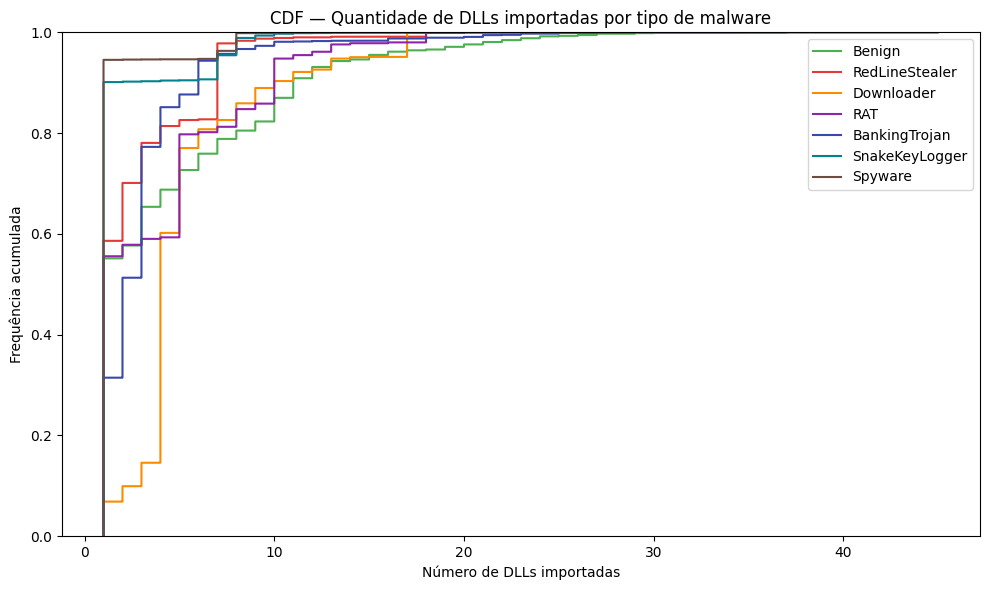

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# CARREGAR OS DADOS
# ==========================
df = pd.read_csv("./dataset/full_df.csv")

# ==========================
# IDENTIFICAR COLUNAS DE DLL
# ==========================
dll_cols = [c for c in df.columns if c.upper().endswith(".DLL")]
print(f"Total DLL features detectadas: {len(dll_cols)}")

# ==========================
# SOMAR QUANTAS DLLS CADA EXECUTAVEL IMPORTA
# ==========================
# caso sejam booleanas, converte para int
df["DLL_Count"] = df[dll_cols].astype(int).sum(axis=1)

# ==========================
# CONVERTER TARGET PARA NOME DO MALWARE
# ==========================
malware_labels = {
    0: "Benign",
    1: "RedLineStealer",
    2: "Downloader",
    3: "RAT",
    4: "BankingTrojan",
    5: "SnakeKeyLogger",
    6: "Spyware"
}

df["MalwareName"] = df["TYPE_x"].map(malware_labels)

# ==========================
# CORES FIXAS POR CLASSE
# ==========================
palette = {
    "Benign": "#4CAF50",
    "RedLineStealer": "#E53935",
    "Downloader": "#FB8C00",
    "RAT": "#8E24AA",
    "BankingTrojan": "#3949AB",
    "SnakeKeyLogger": "#00838F",
    "Spyware": "#6D4C41"
}

# ==========================
# BOX PLOT PARA TODAS AS CLASSES
# ==========================
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="MalwareName", y="DLL_Count", palette=palette)
plt.title("Quantas DLLs executáveis importam — por tipo de malware")
plt.xlabel("Família de Malware")
plt.ylabel("Número de DLLs importadas")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# ==========================
# CDF — FUNÇÃO DISTRIBUIÇÃO ACUMULADA
# ==========================
plt.figure(figsize=(10,6))
for malware, color in palette.items():
    subset = df[df["MalwareName"] == malware]["DLL_Count"]
    sns.ecdfplot(subset, label=malware, color=color)

plt.title("CDF — Quantidade de DLLs importadas por tipo de malware")
plt.xlabel("Número de DLLs importadas")
plt.ylabel("Frequência acumulada")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ============================
# CONFIGURAÇÃO
# ============================
DATA_PATH = "./dataset/full_df.csv"
OUT_DIR = "./eda_outputs1"
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR,"pca_top_features_plots"), exist_ok=True)

# Legenda das classes
CLASS_NAMES = {
    0 : "Benign",
    1 : "RedLineStealer",
    2 : "Downloader",
    3 : "RAT",
    4 : "BankingTrojan",
    5 : "SnakeKeyLogger",
    6 : "Spyware"
}

CLASS_COLORS = {
    0: "#4CAF50",  # verde
    1: "#FF9800",  # laranja
    2: "#9C27B0",  # roxo
    3: "#2196F3",  # azul
    4: "#F44336",  # vermelho
    5: "#795548",  # marrom
    6: "#607D8B"   # cinza azulado
}

# ============================
# 1) Carregar dataset
# ============================
df = pd.read_csv(DATA_PATH)
print("Dataset carregado:", df.shape)

# ============================
# 2) Detectar coluna alvo
# ============================
possible_classes = range(0,7)
target_col = None

for col in df.columns:
    if df[col].dtype in [np.int64, np.int32, np.int16]:
        if set(df[col].unique()).issubset(set(possible_classes)):
            target_col = col
            break

if target_col is None:
    raise ValueError("Nenhuma coluna target com classes 0..6 detectada.")

print("Coluna alvo:", target_col)

# ============================
# 3) Selecionar features numéricas
# ============================
exclude = {target_col}
if "SHA256" in df.columns:
    exclude.add("SHA256")

numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns
                if col not in exclude]

print("Total de features numéricas:", len(numeric_cols))


# ============================
# 4) PCA — seleção de features importantes
# ============================
X = df[numeric_cols].values
X = np.where(np.isfinite(X), X, np.nan)
col_med = np.nanmedian(X, axis=0)
X[np.isnan(X)] = np.take(col_med, np.where(np.isnan(X))[1])

Xs = StandardScaler().fit_transform(X)

pca = PCA(n_components=min(len(numeric_cols), 100), random_state=42)
pca.fit(Xs)

var_ratio = pca.explained_variance_ratio_
cumvar = np.cumsum(var_ratio)

N_keep = np.argmax(cumvar >= 0.95) + 1
print("Componentes PCA necessários p/ 95% variância:", N_keep)

loadings = pca.components_.T[:, :N_keep]
importance = np.sum(np.abs(loadings), axis=1)

feat_rank = pd.DataFrame({
    "feature": numeric_cols,
    "pca_importance": importance
}).sort_values(by="pca_importance", ascending=False)

feat_rank.to_csv(os.path.join(OUT_DIR,"pca_feature_importance.csv"), index=False)

top_feats = feat_rank.head(12)["feature"].tolist()
print("\nTop features selecionadas via PCA:\n", top_feats)

# ============================
# 5) CDF + Boxplots por classe
# ============================
for feat in top_feats:
    plt.figure(figsize=(7,6))
    for c in sorted(df[target_col].unique()):
        vals = df[df[target_col] == c][feat].dropna().values
        vals = np.sort(vals)
        yvals = np.arange(1, len(vals)+1) / len(vals)
        plt.plot(vals, yvals, label=CLASS_NAMES[c], color=CLASS_COLORS[c])
    plt.title(f"CDF - {feat}")
    plt.xlabel(feat)
    plt.ylabel("CDF")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR,"pca_top_features_plots",f"CDF_{feat}.png"))
    plt.close()

for feat in top_feats:
    plt.figure(figsize=(7,6))
    data = []
    labels = []
    for c in sorted(df[target_col].unique()):
        data.append(df[df[target_col] == c][feat].dropna().values)
        labels.append(CLASS_NAMES[c])
    bplot = plt.boxplot(data, patch_artist=True, labels=labels, showfliers=False)
    for patch, c in zip(bplot['boxes'], sorted(df[target_col].unique())):
        patch.set_facecolor(CLASS_COLORS[c])
    plt.title(f"Boxplot por classe - {feat}")
    plt.ylabel(feat)
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR,"pca_top_features_plots",f"BOX_{feat}.png"))
    plt.close()

# ============================
# 6) CDF Especial para SIZEOFCODE
# ============================
if "SIZEOFCODE" in numeric_cols:
    plt.figure(figsize=(7,6))
    for c in sorted(df[target_col].unique()):
        vals = df[df[target_col] == c]["SIZEOFCODE"].dropna().values
        vals = np.sort(vals)
        yvals = np.arange(1, len(vals)+1) / len(vals)
        plt.plot(vals, yvals, label=CLASS_NAMES[c], color=CLASS_COLORS[c])
    plt.title(f"CDF Especial — SIZEOFCODE")
    plt.xlabel("SIZEOFCODE")
    plt.ylabel("CDF")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR,"pca_top_features_plots","CDF_SIZEOFCODE.png"))
    plt.close()

print("\n➡️ Finalizado!")
print("Plots e CSVs gerados em:", OUT_DIR)
